In [61]:
# Load Libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
# tf.compat.v1.disable_eager_execution() # Commented out as per instruction for eager execution
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential, Model # Unify Keras imports
from tensorflow.keras.optimizers import RMSprop, Adam # Unify Keras imports
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input # Unify Keras imports
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from tensorflow.keras.callbacks import EarlyStopping # Unify Keras imports
from tensorflow.keras.callbacks import ModelCheckpoint # Unify Keras imports
from google.colab import files
from numpy import savetxt
from tensorflow.keras.utils import plot_model # Unified import for plot_model
np.random.seed(20)
tf.random.set_seed(20)

In [62]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [64]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel(),'physics_out':data1['physics_out'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()})
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','V_filt','Time','V','SS','physics_out']]
df_SS = df[['freqQAmpI_filt', 'C_filt', 'SS']]
df_V = df[['freqQAmpI_filt', 'C_filt', 'V_filt']]
df_PhyOut = df[['freqQAmpI_filt', 'C_filt', 'physics_out']]
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [65]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (Physics_Out)
arr = df_PhyOut.to_numpy()
n_steps = 300
xdf, phy_outdf = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))
print('Target shape (Physics_Out), Y = ', np.shape(phy_outdf))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
Target shape (Physics_Out), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [66]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Split into train-val-test (Physics Out)
x_train, x_test, y_train_Phy, y_test_Phy = train_test_split(xdf, phy_outdf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_Phy, Y_val_Phy = train_test_split(x_train, y_train_Phy, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[0:92469]
Y_train_SS = Y_train_SS[0:92469]
Y_train_V = Y_train_V[0:92469]
Y_train_Phy = Y_train_Phy[0:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 92469
Validation samples: 13210
Testing samples: 26420


In [67]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [68]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

In [69]:
# Time derivative function
def Time_Derivative(del_t, ss2):
    # Removed global ss1 and simplified to ss2 / del_t for batch compatibility
    Gradient_Value = ss2 / del_t
    return Gradient_Value

**Define Physics-Informed Model**: **Self Learning Constants**

In [70]:
# Define Physics
class gradient_1(tf.keras.layers.Layer):
  def __init__(self):
    super(gradient_1,self).__init__()
    self.SS = tf.keras.layers.Dense(1)
    self.V = tf.keras.layers.Dense(1)
    self.all_scale = tf.keras.layers.Dense(1)
    self.c1 = self.add_weight(name="c1", trainable=True, shape=(), dtype=tf.float32) # Fixed: Explicitly used name=
    self.c2 = self.add_weight(name="c2", trainable=True, shape=(), dtype=tf.float32) # Fixed: Explicitly used name=
    self.c3 = self.add_weight(name="c3", trainable=True, shape=(), dtype=tf.float32) # Fixed: Explicitly used name=

  def call(self, params):
    ss_pred, v_pred = params
    ss_pred = self.SS(ss_pred)
    v_pred = self.V(v_pred)

    # Converted Python numeric constants to tf.constant with explicit dtype
    term1 = Time_Derivative(tf.constant(0.01, dtype=tf.float32), ss_pred)
    term2 = tf.divide(tf.constant(1.0, dtype=tf.float32), self.c1) # Added explicit dtype
    term3 = tf.multiply(term1, term2)
    term4 = (self.c2 - v_pred)
    term5 = tf.multiply(self.c3, term4)
    eqn = term3 - term5
    eqn = self.all_scale(eqn)

    return eqn

In [71]:
# Define PINN
def MLP_Physics():

  # Define inputs
  X_train = layers.Input(shape=(600,),name='X_train')

  # Shear Stress + Slip Rate model
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  grad_out = gradient_1()([ss_pred,v_pred])
  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred,grad_out])
  return model

In [72]:
# Model Summary
model=MLP_Physics()
# Adjusted metrics to match the three outputs of the model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse', 'mse', 'mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_train             │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     76,928 │ X_train[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 16)        │        528 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 8)         │        136 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │          9 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │          9 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gradient_1_2        │ (None, 1)         │          9 │ dense_25[0][0],   │
│ (gradient_1)        │                   │            │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,955 (343.57 KB)

 Trainable params: 87,955 (343.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - dense_25_loss: 0.5186 - dense_25_mse: 0.5186 - dense_26_loss: 0.0086 - dense_26_mse: 0.0086 - gradient_1_2_loss: 0.0029 - gradient_1_2_mse: 0.0029 - loss: 0.5301 - val_dense_25_loss: 0.3533 - val_dense_25_mse: 0.3535 - val_dense_26_loss: 0.0148 - val_dense_26_mse: 0.0147 - val_gradient_1_2_loss: 1.6878e-05 - val_gradient_1_2_mse: 1.6872e-05 - val_loss: 0.3681
Epoch 2/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - dense_25_loss: 0.3574 - dense_25_mse: 0.3574 - dense_26_loss: 0.0086 - dense_26_mse: 0.0086 - gradient_1_2_loss: 6.3284e-04 - gradient_1_2_mse: 6.3284e-04 - loss: 0.3666 - val_dense_25_loss: 0.1282 - val_dense_25_mse: 0.1282 - val_dense_26_loss: 0.0148 - val_dense_26_mse: 0.0147 - val_gradient_1_2_loss: 0.0013 - val_gradient_1_2_mse: 0.0013 - val_loss: 0.1443
Epoch 3/100
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - dense_25_loss: 0.0763 - dense_25_mse: 0.0763 - dense_26_loss: 0.0086 - dense_26_mse: 0.0086 - gradient

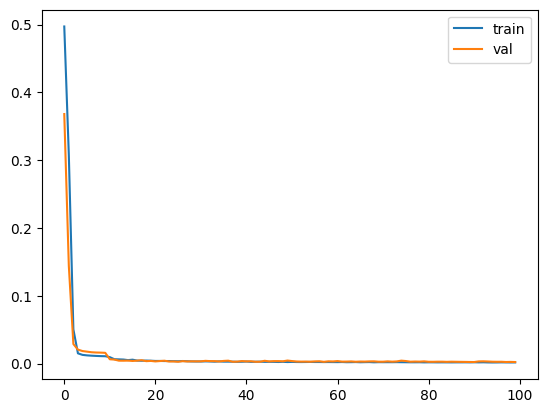

In [74]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100,verbose=1, mode='auto')
callbacks_list = [earlystop]

# Convert all training and validation data to NumPy arrays before passing to model.fit
X_train_np = X_train.to_numpy()
Y_train_SS_np = Y_train_SS.to_numpy()
Y_train_V_np = Y_train_V.to_numpy()
Y_train_Phy_np = Y_train_Phy # Y_train_Phy is already a NumPy array, no .to_numpy() needed

X_val_np = X_val.to_numpy()
Y_val_SS_np = Y_val_SS.to_numpy()
Y_val_V_np = Y_val_V.to_numpy()
Y_val_Phy_np = Y_val_Phy # Y_val_Phy is already a NumPy array, no .to_numpy() needed


history = model.fit([X_train_np],[Y_train_SS_np, Y_train_V_np, Y_train_Phy_np], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val_np],[Y_val_SS_np, Y_val_V_np, Y_val_Phy_np]), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [75]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/PINN_1/PINN_Transfer_model_70_10_20.h5')

In [76]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,]
y_predtrain_V =np.array(y_predtrain)[1,]

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

train_r2_V = r2_score(Y_train_V,y_predtrain_V )
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V ))

# Model Performance: Validation
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,]
y_predval_V = np.array(y_predval)[1,]

val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

val_r2_V = r2_score(Y_val_V, y_predval_V)
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V))

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,]
y_predtest_V = np.array(y_predtest)[1,]

test_r2_SS = r2_score(y_test_SS,y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

test_r2_V = r2_score(y_test_V,y_predtest_V)
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V))

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

2890/2890 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R2 scores: Train (SS) - 0.97590, Train (V) - 0.91864
R2 scores: Validation (SS) - 0.97100, Validation (V) - 0.90815
R2 scores: Testing (SS) - 0.93538, Testing (V) - 0.86541
RMSE scores: Train (SS) - 0.02530, Train (V) - 0.02743
RMSE scores: Validation (SS) - 0.03204, Validation (V) - 0.03668
RMSE scores: Testing (SS) - 0.04686, Testing (V) - 0.04314


In [77]:
# Inverse scaling: SS
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [78]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

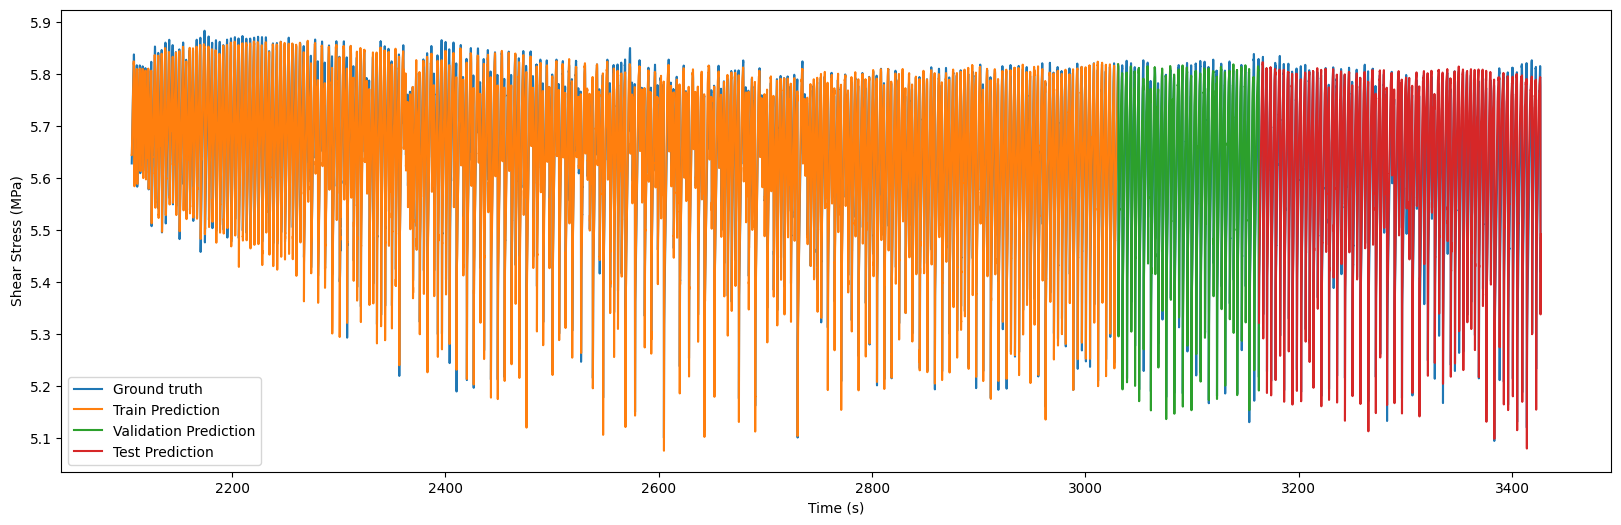

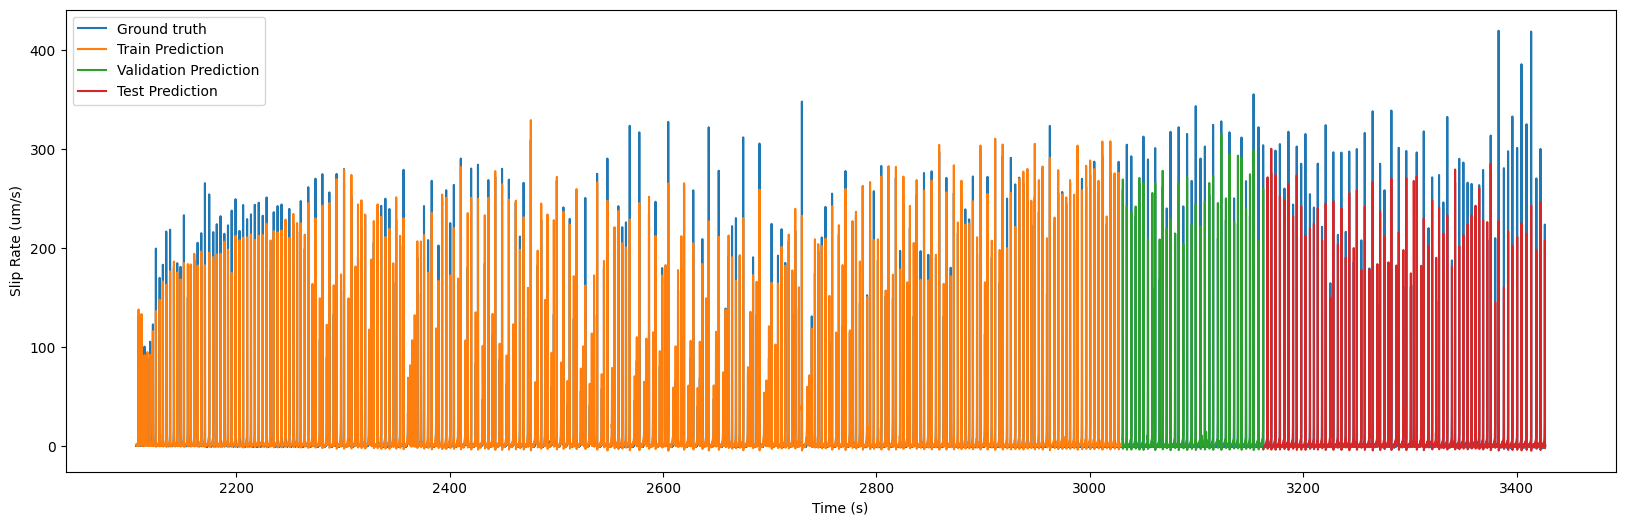

In [79]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:92469]

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

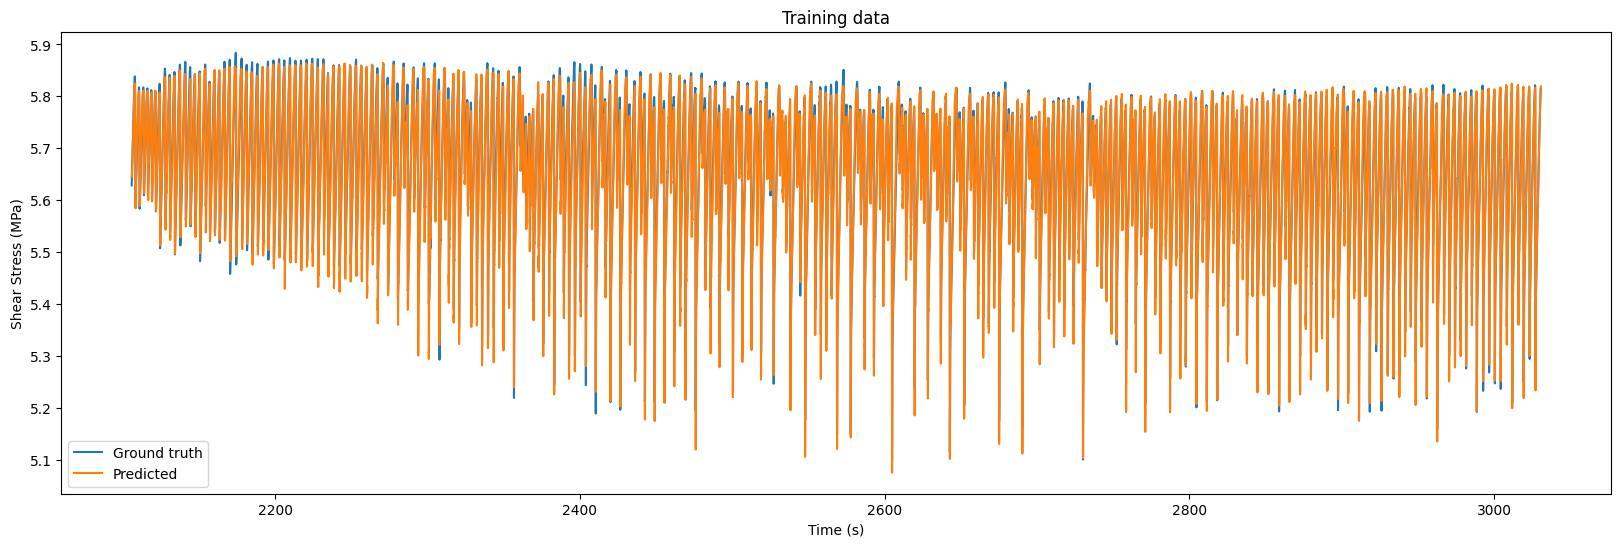

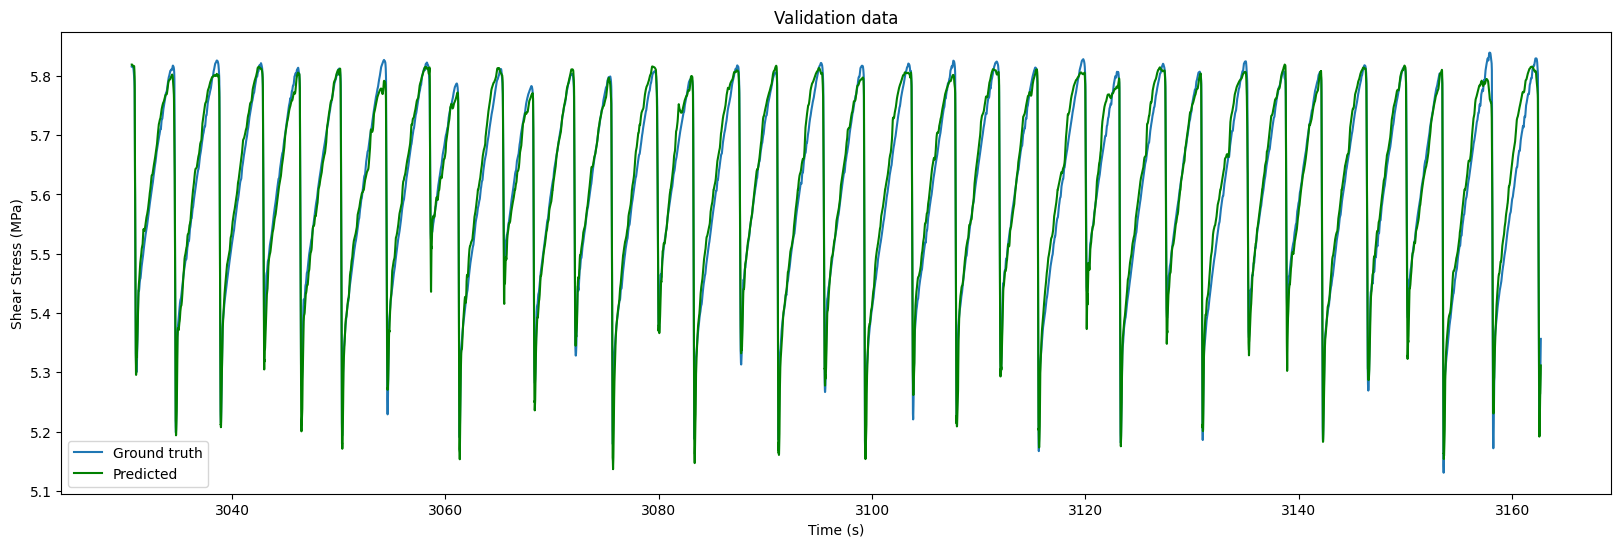

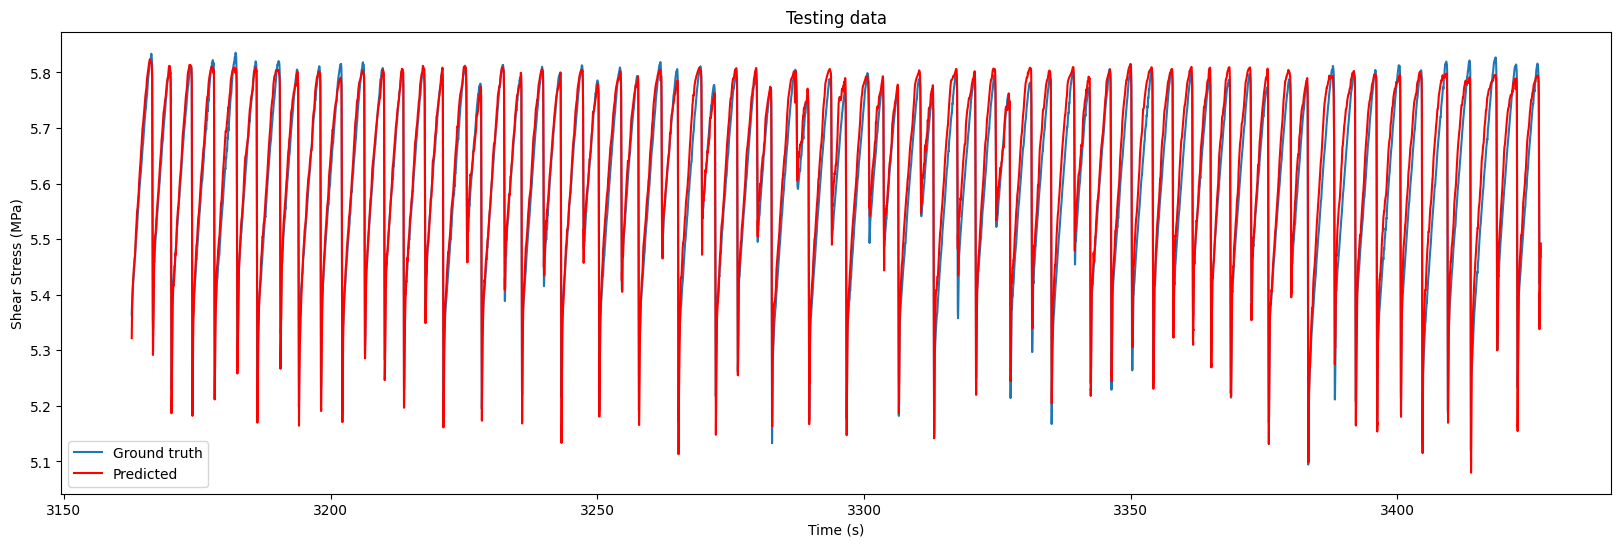

In [80]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

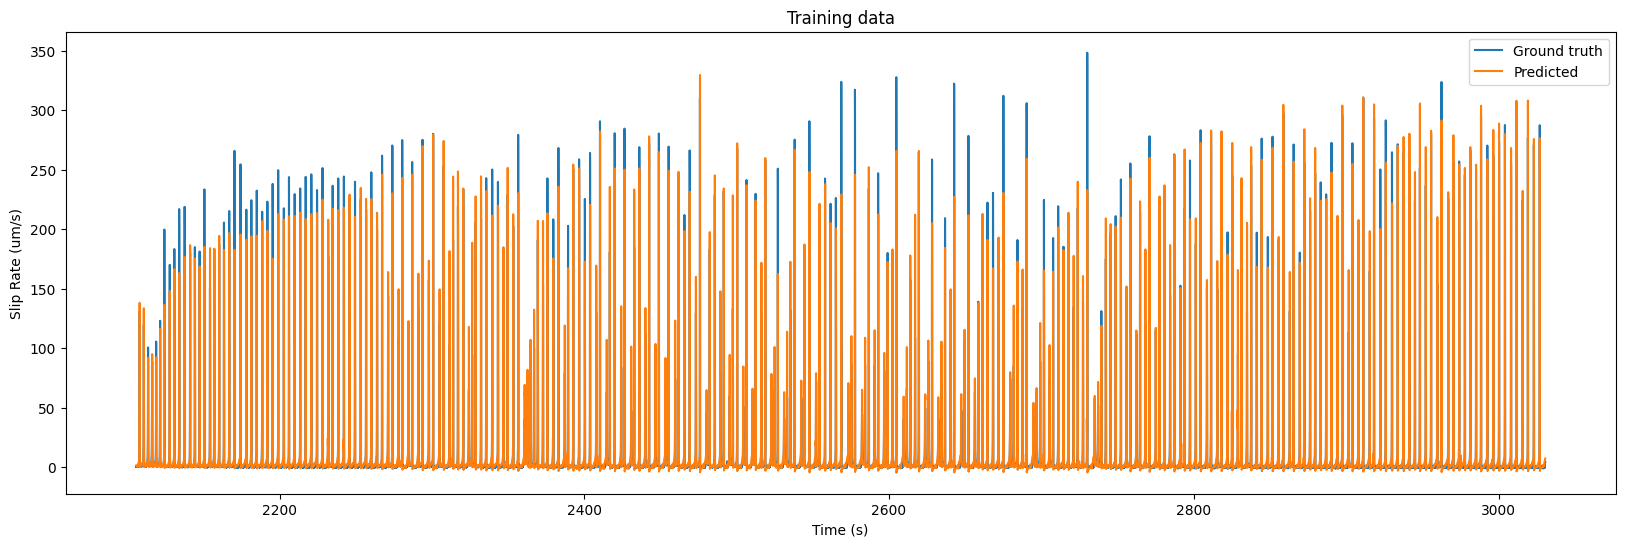

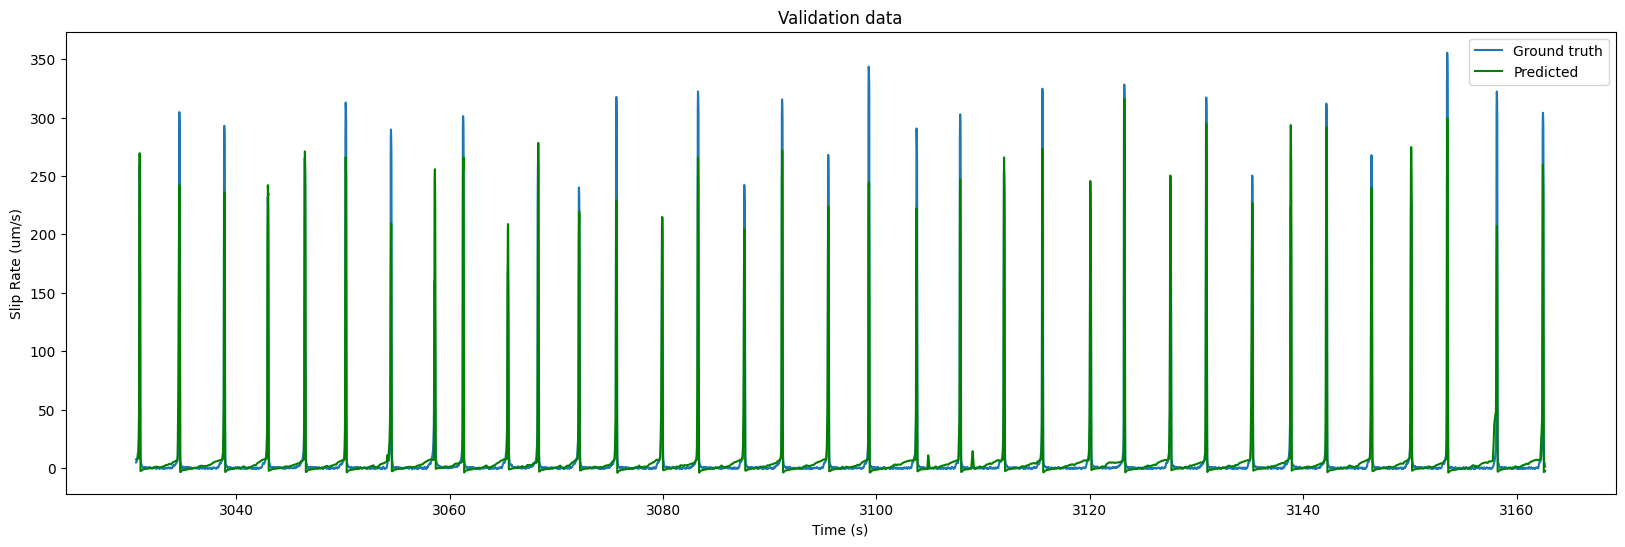

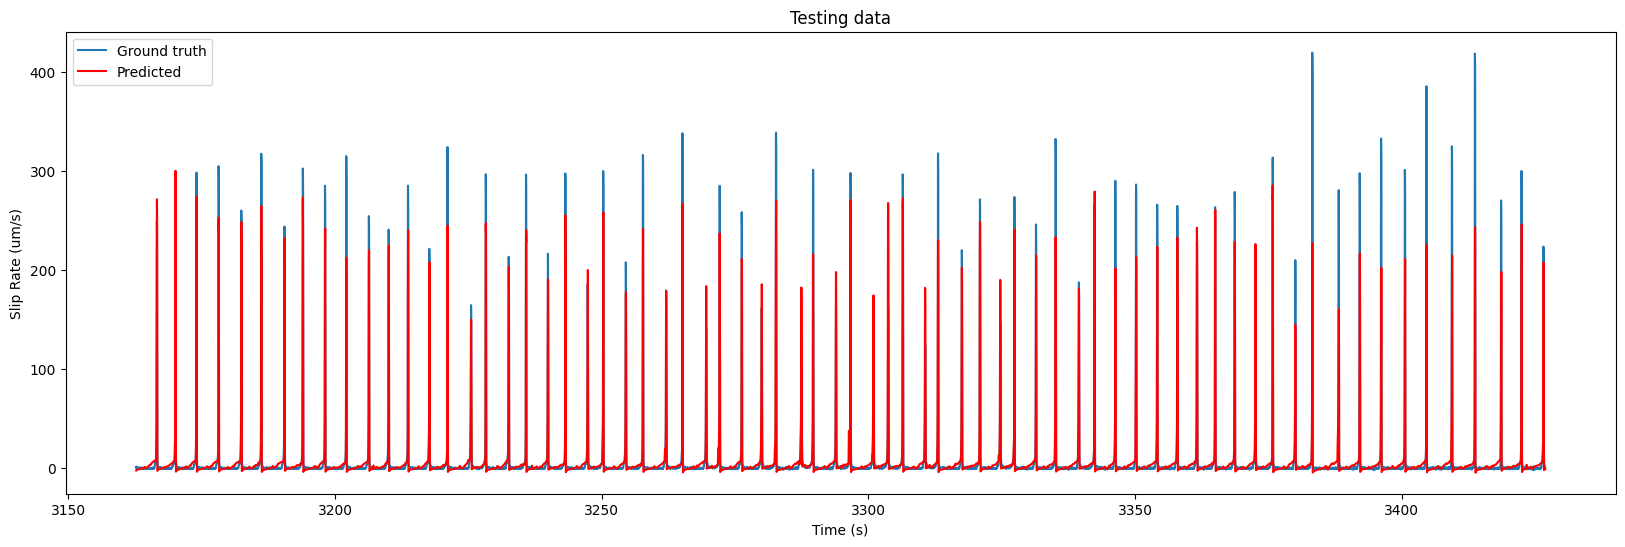

In [81]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [82]:
# Extarct Weights
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

kernel (600, 128)
bias (128,)
kernel (128, 64)
bias (64,)
kernel (64, 32)
bias (32,)
kernel (32, 16)
bias (16,)
kernel (16, 8)
bias (8,)
kernel (8, 1)
bias (1,)
kernel (8, 1)
bias (1,)
c1 ()
c2 ()
c3 ()
kernel (1, 1)
bias (1,)
kernel (1, 1)
bias (1,)
kernel (1, 1)
bias (1,)


In [83]:
# Display Weights
model.get_weights()

[array([[-0.06413389,  0.04397955, -0.00950998, ..., -0.05687619,
         -0.04702612, -0.09898524],
        [ 0.07900029,  0.0501149 ,  0.03062392, ...,  0.05431818,
          0.10024666,  0.02696647],
        [ 0.03844397,  0.03944868,  0.05565277, ..., -0.04928987,
         -0.02921782, -0.04017365],
        ...,
        [-0.03527861,  0.01032922,  0.0380022 , ..., -0.0002277 ,
         -0.02366132, -0.03974057],
        [ 0.04386709,  0.02748848, -0.00018794, ...,  0.05225185,
         -0.00412066,  0.0049388 ],
        [-0.04830793,  0.02857224,  0.05582949, ..., -0.0318279 ,
         -0.04064044,  0.07831597]], dtype=float32),
 array([ 2.37984955e-01, -5.96726080e-03,  0.00000000e+00, -1.25551727e-02,
         0.00000000e+00, -1.21982835e-01,  0.00000000e+00,  4.22872365e-01,
        -5.84654370e-03, -7.00716954e-03,  3.67799312e-01, -2.49276077e-03,
         6.90277386e-03, -5.93053270e-03,  0.00000000e+00,  0.00000000e+00,
        -8.41789879e-03, -6.53163251e-03,  0.00000000e

In [84]:
# ML Learned Constants

# Normal Stress
r1 = 10/5.89
cols = ['NS']
data = pd.DataFrame(np.array([[3.03]]),columns=cols)
NS = scaler_ss.inverse_transform(data)
NS = NS*r1

# Shear Loading Velocity
dt = 0.01
cols = ['VL']
data = pd.DataFrame(np.array([[1.11]]),columns=cols)
VL = scaler_v.inverse_transform(data)
VL = (VL*dt)*r1

# Stiffness
k = ((0.32*dt)*r1)*r1

print("Normal Stress:",NS)
print("Shear Loading Velocity:",VL)
print("Stiffness:",k)

Normal Stress: [[12.69132266]]
Shear Loading Velocity: [[6.5629475]]
Stiffness: 0.009224002006220438
